In [1]:
# Import the class from the Python file (module)
import pandas as pd
import matplotlib.pyplot as plt
import os
# from dotenv import load_dotenv
# from pathlib import Path
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from BinanceClient import BinanceClient
import numpy as np
from typing import Final
import joblib
from BatchFeatures import BatchFeatures
from datetime import datetime, timedelta
%matplotlib widget

## Load pair df

In [2]:
import os
from datetime import datetime, timedelta, timezone
from pathlib import Path
import re
import pandas as pd
import requests

DB_DIR = Path("dbs")
BAD_SUFFIXES = ("UPUSDT","DOWNUSDT","BULLUSDT","BEARUSDT","3LUSDT","3SUSDT","5LUSDT","5SUSDT")


def interval_slug(s: str) -> str:
    return s.strip().replace(" ", "").replace("/", "").lower()

def make_db_name(pair: str, interval: str, weeks: int) -> str:
    return f"{pair}_{interval_slug(interval)}_{weeks}weeks.db"

def list_downloaded_pairs(db_dir=DB_DIR):
    """
    Returns list of symbols inferred from SQLite filenames in db_dir.
    Assumes file contains a token like BTCUSDT somewhere in the name.
    """
    symbols = set()

    for p in Path(db_dir).glob("*.db"):
        name = p.stem  # filename without extension
        # find the first token that looks like a Binance symbol ending with USDT
        m = re.search(r"([A-Z0-9]{2,20}USDT)", name.upper())
        if m:
            symbols.add(m.group(1))

    # filter out leveraged tokens etc
    symbols = [s for s in symbols if s.endswith("USDT") and not s.endswith(BAD_SUFFIXES)]
    return sorted(symbols)
    
def load_or_fetch_pair_df(pair: str, interval: str, weeks: int) -> tuple[str, "pd.DataFrame"]:
    db_name = make_db_name(pair, interval, weeks)
    db_path = "./db/" + db_name

    print(f"[{pair}] DB: {db_path}")

    binance_client = BinanceClient(db_path)
    binance_client.set_interval(interval)

    df = None

    if os.path.exists(db_path):
        df = binance_client.fetch_data_from_db(pair)
        if df is not None and not df.empty:
            print(f"[{pair}] Loaded {len(df):,} rows from DB.")
        else:
            df = None

    if df is None:
        print(f"[{pair}] No usable DB data found -> fetching from Binance...")

        api_secret = os.getenv("BINANCE_SECRET_KEY")
        api_key = os.getenv("BINANCE_API_KEY")
        binance_client.make(api_key, api_secret)

        server_time = binance_client.get_server_time()
        end_dt = datetime.fromtimestamp(server_time["serverTime"] / 1000, tz=timezone.utc)
        start_dt = end_dt - timedelta(weeks=weeks)

        start_ms = int(start_dt.timestamp() * 1000)
        end_ms = int(end_dt.timestamp() * 1000)

        data = binance_client.fetch_data(pair, start_ms, end_ms)
        if data is None or data.empty:
            raise RuntimeError(f"[{pair}] No data returned from Binance for the requested range.")

        binance_client.store_data_to_db(pair, data)

        df = binance_client.fetch_data_from_db(pair)
        if df is None or df.empty:
            raise RuntimeError(f"[{pair}] Data fetched/stored but DB load returned empty.")

        print(f"[{pair}] Fetched + stored + loaded {len(df):,} rows.")

    df = df.sort_index()
    return db_path, df


In [7]:
import pandas as pd
import numpy as np

def detect_volume_shocks(
    df,
    vol_win=144,          # 12h median
    impulse_k=12,         # 60 min impulse
    rvol_thresh=6.0,
    impulse_thresh=0.04,
    lookahead=24,
    cooldown=12,
):
    d = df[["open","high","low","close","volume"]].dropna().copy()

    vol_med = d["volume"].rolling(vol_win).median()
    rvol = d["volume"] / vol_med
    impulse = d["close"] / d["close"].shift(impulse_k) - 1

    events = []
    i = 0

    while i < len(d) - lookahead:
        if rvol.iloc[i] >= rvol_thresh and impulse.iloc[i] >= impulse_thresh:
            px0 = d["close"].iloc[i]
            future = d["close"].iloc[i+1:i+1+lookahead]

            events.append({
                "event_ts": d.index[i],
                "close_event": px0,
                "rvol": float(rvol.iloc[i]),
                "impulse": float(impulse.iloc[i]),
            })
            i += cooldown
        else:
            i += 1

    return pd.DataFrame(events)


# def detect_volume_events(
#     df: pd.DataFrame,
#     symbol: str,
#     vol_win: int = 144,          # 12 hours on 5m
#     impulse_k: int = 12,         # 60 min impulse
#     rvol_thresh: float = 6.0,    # strict
#     impulse_thresh: float = 0.04,# +4% over impulse_k
#     lookahead: int = 24,         # 2 hours forward path
#     cooldown: int = 12,          # avoid logging same burst repeatedly (60 min)
# ):
#     """
#     Logs candidate 'flow shock' events:
#       - RVOL spike relative to rolling median
#       - Positive impulse over last impulse_k bars
#     Then measures forward path stats over lookahead bars.
#     """
#     d = df.copy().sort_index()
#     d = d[["open","high","low","close","volume"]].dropna()

#     vol_med = d["volume"].rolling(vol_win).median()
#     rvol = d["volume"] / vol_med
#     impulse = d["close"] / d["close"].shift(impulse_k) - 1.0

#     out = []
#     i = 0
#     n = len(d)

#     while i < n - lookahead:
#         if (rvol.iloc[i] >= rvol_thresh) and (impulse.iloc[i] >= impulse_thresh):
#             px0 = float(d["close"].iloc[i])
#             ts0 = d.index[i]

#             future = d["close"].iloc[i+1:i+1+lookahead]
#             fmax = float(future.max())
#             fmin = float(future.min())
#             max_fwd_return = fmax / px0 - 1.0
#             max_drawdown = fmin / px0 - 1.0

#             # retrace from the peak within the lookahead window
#             # find peak time then worst after that peak
#             peak_idx = future.values.argmax()
#             peak_px = float(future.iloc[peak_idx])
#             after_peak = future.iloc[peak_idx:]  # includes peak bar
#             trough_after_peak = float(after_peak.min())
#             max_retrace = trough_after_peak / peak_px - 1.0  # negative means retrace

#             # time to max retrace (bars after event)
#             trough_idx = after_peak.values.argmin()
#             time_to_max_retrace_bars = int(peak_idx + trough_idx + 1)

#             out.append({
#                 "symbol": symbol,
#                 "event_ts": ts0,
#                 "close_event": px0,
#                 "rvol": float(rvol.iloc[i]),
#                 "impulse": float(impulse.iloc[i]),
#                 "max_fwd_return": max_fwd_return,
#                 "max_drawdown": max_drawdown,
#                 "max_retrace": max_retrace,
#                 "time_to_max_retrace_bars": time_to_max_retrace_bars,
#             })

#             i += cooldown  # skip ahead so we don't log every bar of the same burst
#         else:
#             i += 1

#     return pd.DataFrame(out)


In [3]:
interval = "5m"
weeks = 52

paths = {}
dfs = {}

pairs = list_downloaded_pairs("db")

for sym in pairs:
    db_path, df = load_or_fetch_pair_df(sym, interval, weeks)
    paths[sym] = db_path
    dfs[sym] = df
    dfs[sym] = df


[0GUSDT] DB: ./db/0GUSDT_5m_52weeks.db
[0GUSDT] Loaded 36,249 rows from DB.
[1INCHUSDT] DB: ./db/1INCHUSDT_5m_52weeks.db
[1INCHUSDT] Loaded 104,832 rows from DB.
[2ZUSDT] DB: ./db/2ZUSDT_5m_52weeks.db
[2ZUSDT] Loaded 33,383 rows from DB.
[AAVEUSDT] DB: ./db/AAVEUSDT_5m_52weeks.db
[AAVEUSDT] Loaded 104,832 rows from DB.
[ADAUSDT] DB: ./db/ADAUSDT_5m_52weeks.db
[ADAUSDT] Loaded 104,832 rows from DB.
[AGLDUSDT] DB: ./db/AGLDUSDT_5m_52weeks.db
[AGLDUSDT] Loaded 104,832 rows from DB.
[ALGOUSDT] DB: ./db/ALGOUSDT_5m_52weeks.db
[ALGOUSDT] Loaded 104,832 rows from DB.
[ALLOUSDT] DB: ./db/ALLOUSDT_5m_52weeks.db
[ALLOUSDT] Loaded 21,807 rows from DB.
[APTUSDT] DB: ./db/APTUSDT_5m_52weeks.db
[APTUSDT] Loaded 104,832 rows from DB.
[ARBUSDT] DB: ./db/ARBUSDT_5m_52weeks.db
[ARBUSDT] Loaded 104,832 rows from DB.
[ASTERUSDT] DB: ./db/ASTERUSDT_5m_52weeks.db
[ASTERUSDT] Loaded 32,185 rows from DB.
[ASTRUSDT] DB: ./db/ASTRUSDT_5m_52weeks.db
[ASTRUSDT] Loaded 104,832 rows from DB.
[AUCTIONUSDT] DB: ./db/

## Load COINS, then align timestamps

In [9]:
events = []

for sym, df in dfs.items():
    ev = detect_volume_shocks(df)      # ✅ no sym passed
    if not ev.empty:
        ev["symbol"] = sym
        events.append(ev)

events = pd.concat(events, ignore_index=True) if events else pd.DataFrame()


In [10]:
len(events)            # should be thousands, not tens
events["impulse"].describe()
events["rvol"].describe()


count    6289.000000
mean       31.162383
std       104.710579
min         6.000611
25%         7.835112
50%        11.619263
75%        22.839509
max      4502.710521
Name: rvol, dtype: float64

## Get all Binance coin pairs

In [ ]:
import requests
import pandas as pd

BINANCE_REST = "https://api.binance.com"

def get_spot_usdt_symbols():
    """All Spot symbols that trade against USDT and are currently TRADING."""
    info = requests.get(f"{BINANCE_REST}/api/v3/exchangeInfo", timeout=20).json()
    syms = []
    for s in info["symbols"]:
        if s.get("status") != "TRADING":
            continue
        if s.get("isSpotTradingAllowed") is not True:
            continue
        if s.get("quoteAsset") != "USDT":
            continue

        sym = s["symbol"]

        # Exclude leveraged tokens & some common non-spot-like tickers
        bad_substrings = ["UPUSDT", "DOWNUSDT", "BULLUSDT", "BEARUSDT", "3LUSDT", "3SUSDT", "5LUSDT", "5SUSDT"]
        if any(sym.endswith(x) for x in bad_substrings):
            continue

        syms.append(sym)
    return sorted(set(syms))

def rank_symbols_by_quote_volume(symbols):
    """Return DataFrame of symbols with 24h quoteVolume (USDT) sorted desc."""
    tickers = requests.get(f"{BINANCE_REST}/api/v3/ticker/24hr", timeout=20).json()
    # Build a map for fast lookup
    wanted = set(symbols)

    rows = []
    for t in tickers:
        sym = t.get("symbol")
        if sym not in wanted:
            continue
        # quoteVolume is in quoteAsset units, here USDT
        qv = float(t.get("quoteVolume", 0.0))
        rows.append({
            "symbol": sym,
            "quoteVolumeUSDT_24h": qv,
            "lastPrice": float(t.get("lastPrice", 0.0)),
            "priceChangePercent": float(t.get("priceChangePercent", 0.0)),
            "count": int(t.get("count", 0)),  # trade count 24h
        })

    df = pd.DataFrame(rows)
    df = df.sort_values("quoteVolumeUSDT_24h", ascending=False).reset_index(drop=True)
    return df

def get_top_usdt_pairs(n=100, min_quote_vol_usdt=None):
    """Top-N by 24h quote volume; optionally filter by minimum quote volume."""
    syms = get_spot_usdt_symbols()
    ranked = rank_symbols_by_quote_volume(syms)

    if min_quote_vol_usdt is not None:
        ranked = ranked[ranked["quoteVolumeUSDT_24h"] >= float(min_quote_vol_usdt)].copy()

    top = ranked.head(n).copy()
    return top, ranked


In [ ]:
top100, ranked_all = get_top_usdt_pairs(n=100)
pairs = top100["symbol"].tolist()

len(pairs)


## Detect Comporession state

In [ ]:
import pandas as pd
import numpy as np

def detect_compression_state(
    df: pd.DataFrame,
    *,
    atr_short: int = 20,          # ~100 min on 5m
    atr_long: int = 100,          # ~8 hours on 5m
    vol_win: int = 144,           # volume median window (12 hours)
    vol_ratio_thresh: float = 0.6,
    rvol_thresh: float = 0.6,
    min_duration: int = 12        # bars of sustained compression (60 min)
):
    """
    Detects pre-shock compression state.

    Returns df with added columns:
      - atr
      - atr_med
      - vol_compression
      - rvol
      - volu_compression
      - compression_raw
      - compression_duration
      - is_compressed
    """

    d = df.copy().sort_index()
    d = d[["open","high","low","close","volume"]].dropna()

    # -----------------------
    # 1) Volatility (ATR)
    # -----------------------
    high = d["high"]
    low  = d["low"]
    close = d["close"]

    tr = pd.concat([
        high - low,
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ], axis=1).max(axis=1)

    d["atr"] = tr.rolling(atr_short).mean()
    d["atr_med"] = d["atr"].rolling(atr_long).median()

    d["vol_compression"] = d["atr"] / d["atr_med"]
    d["is_vol_compressed"] = d["vol_compression"] <= vol_ratio_thresh

    # -----------------------
    # 2) Volume compression
    # -----------------------
    vol_med = d["volume"].rolling(vol_win).median()
    d["rvol"] = d["volume"] / vol_med
    d["is_volume_compressed"] = d["rvol"] <= rvol_thresh

    # -----------------------
    # 3) Raw compression flag
    # -----------------------
    d["compression_raw"] = (
        d["is_vol_compressed"] &
        d["is_volume_compressed"]
    )

    # -----------------------
    # 4) Duration counter
    # -----------------------
    duration = np.zeros(len(d), dtype=int)

    for i in range(1, len(d)):
        if d["compression_raw"].iloc[i]:
            duration[i] = duration[i-1] + 1
        else:
            duration[i] = 0

    d["compression_duration"] = duration

    # -----------------------
    # 5) Final state
    # -----------------------
    d["is_compressed"] = d["compression_duration"] >= min_duration

    return d


In [ ]:
df = dfs["BTCUSDT"]
df_c = detect_compression_state(df)

df_c[["vol_compression","rvol","compression_duration","is_compressed"]].tail(30)


In [ ]:
df_c["is_compressed"].mean()

In [ ]:
def get_compression_times(df_c):
    """
    df_c = output of detect_compression_state(df)
    Returns DatetimeIndex of bars where compression starts
    (we take the FIRST bar of each compression block)
    """
    comp = df_c["is_compressed"]

    # compression start = is_compressed == True AND previous == False
    comp_start = comp & (~comp.shift(1).fillna(False))

    return df_c.index[comp_start]

def get_shock_times(events_sym):
    """
    events_sym = events filtered to one symbol
    Returns DatetimeIndex of shock timestamps
    """
    return pd.to_datetime(events_sym["event_ts"]).sort_values()

def compression_leads_shock(
    compression_times,
    shock_times,
    *,
    max_lead_minutes=120
):
    """
    For each compression start time, check whether
    a shock occurs within max_lead_minutes AFTER it.
    """
    lead_td = pd.Timedelta(minutes=max_lead_minutes)

    hits = 0
    for t in compression_times:
        if ((shock_times > t) & (shock_times <= t + lead_td)).any():
            hits += 1

    total = len(compression_times)

    return {
        "compression_events": total,
        "hits": hits,
        "hit_rate": hits / total if total > 0 else np.nan
    }



In [ ]:
import numpy as np
import pandas as pd

# -----------------------------
# Helpers: ATR + linear slope
# -----------------------------
def _atr14(series_df: pd.DataFrame, n: int = 14) -> pd.Series:
    h = series_df["high"]
    l = series_df["low"]
    c = series_df["close"]
    tr = pd.concat(
        [(h - l), (h - c.shift()).abs(), (l - c.shift()).abs()],
        axis=1
    ).max(axis=1)
    return tr.rolling(n).mean()

def _lin_slope(y: np.ndarray) -> float:
    """Slope of y versus index (0..n-1). Returns 0 if too short or constant."""
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n < 3 or np.all(~np.isfinite(y)):
        return np.nan
    x = np.arange(n, dtype=float)
    y = y - np.nanmean(y)
    x = x - x.mean()
    denom = np.nansum(x * x)
    return float(np.nansum(x * y) / denom) if denom > 0 else 0.0

# -----------------------------
# Candle overlap + wick/body
# -----------------------------
def _overlap_ratio(window: pd.DataFrame) -> float:
    """Mean normalized overlap between consecutive candles (0..1-ish)."""
    if len(window) < 2:
        return np.nan
    h = window["high"].to_numpy(dtype=float)
    l = window["low"].to_numpy(dtype=float)
    rng = (h - l)
    rng[rng == 0] = np.nan

    # overlap between t and t-1
    ov = np.minimum(h[1:], h[:-1]) - np.maximum(l[1:], l[:-1])
    ov = np.maximum(ov, 0.0)
    # normalize by current candle range
    ov_norm = ov / rng[1:]
    return float(np.nanmean(ov_norm))

def _wick_to_body_ratio(window: pd.DataFrame) -> float:
    """(upper+lower wick)/body averaged over window."""
    o = window["open"].to_numpy(dtype=float)
    c = window["close"].to_numpy(dtype=float)
    h = window["high"].to_numpy(dtype=float)
    l = window["low"].to_numpy(dtype=float)

    body = np.abs(c - o)
    body[body == 0] = np.nan

    upper = h - np.maximum(o, c)
    lower = np.minimum(o, c) - l
    wick = upper + lower
    return float(np.nanmean(wick / body))

# -----------------------------
# Feature extraction for one window
# -----------------------------
def extract_window_features(
    d: pd.DataFrame,
    t0: pd.Timestamp,
    *,
    pre_bars: int = 36,        # 180 min
    gap_bars: int = 2,         # exclude last 10 min
    atr_long_med_win: int = 144 # 12h baseline for median
) -> dict | None:
    """
    Compute pre-shock window features for a single event time t0.

    Window is: [t0 - pre_bars, t0 - gap_bars]
    Assumes d is indexed by datetime and has open/high/low/close/volume.
    """
    if not isinstance(d.index, pd.DatetimeIndex):
        raise ValueError("df must have a DatetimeIndex")

    # Ensure sorted
    d = d.sort_index()

    # Need baseline columns
    if "atr14" not in d.columns:
        d["atr14"] = _atr14(d, 14)
    if "vol_med_12h" not in d.columns:
        d["vol_med_12h"] = d["volume"].rolling(atr_long_med_win).median()
    if "rvol_12h" not in d.columns:
        d["rvol_12h"] = d["volume"] / d["vol_med_12h"]
    if "atr14_med_12h" not in d.columns:
        d["atr14_med_12h"] = d["atr14"].rolling(atr_long_med_win).median()

    # Locate t0
    if t0 not in d.index:
        # if exact timestamp missing, align to nearest previous bar
        loc = d.index.searchsorted(t0, side="right") - 1
        if loc < 0:
            return None
        t0 = d.index[loc]

    end_loc = d.index.get_loc(t0) - gap_bars
    start_loc = end_loc - pre_bars + 1

    if start_loc < 0 or end_loc <= start_loc:
        return None

    w = d.iloc[start_loc:end_loc+1].copy()
    if len(w) < max(10, pre_bars // 2):
        return None

    # Baselines at window end (most relevant "current regime")
    atr_med = d["atr14_med_12h"].iloc[end_loc]
    if not np.isfinite(atr_med) or atr_med <= 0:
        return None

    # Features
    atr_mean = float(np.nanmean(w["atr14"].to_numpy(dtype=float)))
    atr_mean_ratio = atr_mean / float(atr_med)

    atr_slope = _lin_slope(w["atr14"].to_numpy(dtype=float))
    rvol_mean = float(np.nanmean(w["rvol_12h"].to_numpy(dtype=float)))
    rvol_slope = _lin_slope(w["rvol_12h"].to_numpy(dtype=float))

    window_high = float(np.nanmax(w["high"]))
    window_low  = float(np.nanmin(w["low"]))
    window_close = float(w["close"].iloc[-1])
    range_pct = (window_high - window_low) / window_close if window_close != 0 else np.nan

    overlap_ratio = _overlap_ratio(w)
    wick_to_body = _wick_to_body_ratio(w)

    return {
        "t0": t0,
        "win_start": w.index[0],
        "win_end": w.index[-1],
        "atr_mean_ratio": atr_mean_ratio,
        "atr_slope": atr_slope,
        "rvol_mean": rvol_mean,
        "rvol_slope": rvol_slope,
        "range_pct": range_pct,
        "overlap_ratio": overlap_ratio,
        "wick_to_body_ratio": wick_to_body,
    }

# -----------------------------
# Build dataset: shock vs control
# -----------------------------
def build_preshock_dataset(
    dfs: dict[str, pd.DataFrame],
    events: pd.DataFrame,
    *,
    pre_bars: int = 36,
    gap_bars: int = 2,
    control_per_event: int = 1,
    control_lookahead_bars: int = 36,   # control must have NO shock in next 3h
    seed: int = 42,
) -> pd.DataFrame:
    """
    Returns a labeled dataset with:
      label=1 for pre-shock windows
      label=0 for matched control windows (same symbol, same window length)
    """
    rng = np.random.default_rng(seed)

    ev = events.copy()
    ev["event_ts"] = pd.to_datetime(ev["event_ts"])
    ev = ev.sort_values(["symbol", "event_ts"])

    rows = []

    # Precompute shock times per symbol for fast control selection
    shock_times_by_sym = {
        sym: pd.to_datetime(g["event_ts"]).sort_values().to_numpy(dtype="datetime64[ns]")
        for sym, g in ev.groupby("symbol")
    }

    for sym, g in ev.groupby("symbol"):
        if sym not in dfs or dfs[sym].empty:
            continue

        d = dfs[sym].copy().sort_index()
        d = d[["open","high","low","close","volume"]].dropna()
        if len(d) < (pre_bars + gap_bars + 200):
            continue

        # Make sure index is datetime
        if not isinstance(d.index, pd.DatetimeIndex):
            raise ValueError(f"{sym} df index must be DatetimeIndex")

        # Precompute baseline columns once per symbol
        d["atr14"] = _atr14(d, 14)
        d["vol_med_12h"] = d["volume"].rolling(144).median()
        d["rvol_12h"] = d["volume"] / d["vol_med_12h"]
        d["atr14_med_12h"] = d["atr14"].rolling(144).median()

        shock_times = shock_times_by_sym.get(sym, np.array([], dtype="datetime64[ns]"))

        for t0 in pd.to_datetime(g["event_ts"]):
            # --- Positive (pre-shock) ---
            feat = extract_window_features(
                d, t0, pre_bars=pre_bars, gap_bars=gap_bars
            )
            if feat is None:
                continue

            feat.update({"symbol": sym, "label": 1})
            rows.append(feat)

            # --- Controls (non-shock) ---
            # We sample control windows that are NOT too close to any shock:
            # specifically: no shock in [t_ctrl, t_ctrl + control_lookahead_bars]
            # and the control window itself must exist.
            if control_per_event <= 0:
                continue

            # Candidate range: pick end_loc such that start_loc >= 0 and end_loc within df
            end_min = pre_bars + gap_bars  # minimal index for t0 location
            end_max = len(d) - control_lookahead_bars - 1
            if end_max <= end_min:
                continue

            # Convert shock_times to pandas index positions for quick exclusion
            # We'll just exclude by time comparisons (simpler, good enough)
            attempts = 0
            got = 0
            while got < control_per_event and attempts < 200:
                attempts += 1
                end_loc = int(rng.integers(end_min, end_max))
                t_ctrl = d.index[end_loc]  # treat as "event time"

                # Exclude if within pre_bars of start or near this shock t0 to avoid leakage
                if abs((t_ctrl - feat["t0"]).total_seconds()) < 6 * 3600:
                    continue

                # Check: no shock in next lookahead window
                t1 = t_ctrl
                t2 = t_ctrl + pd.Timedelta(minutes=5 * control_lookahead_bars)

                if shock_times.size > 0:
                    # numpy datetime64 compare
                    t1n = np.datetime64(t1.to_datetime64())
                    t2n = np.datetime64(t2.to_datetime64())
                    has_future_shock = np.any((shock_times > t1n) & (shock_times <= t2n))
                    if has_future_shock:
                        continue

                feat_c = extract_window_features(
                    d, t_ctrl, pre_bars=pre_bars, gap_bars=gap_bars
                )
                if feat_c is None:
                    continue

                feat_c.update({"symbol": sym, "label": 0})
                rows.append(feat_c)
                got += 1

    return pd.DataFrame(rows)


In [ ]:
# Build dataset
ds = build_preshock_dataset(
    dfs=dfs,
    events=events,
    pre_bars=36,            # 180 min
    gap_bars=2,             # exclude last 10 min
    control_per_event=1,    # start with 1:1 matching
    control_lookahead_bars=36,  # control has no shock in next 3h
    seed=42
)

ds.shape, ds["label"].value_counts()


In [ ]:
# Any NaNs?
ds.isna().mean().sort_values(ascending=False).head(10)

# Compare distributions quickly (shock vs control)
cols = ["atr_mean_ratio","atr_slope","rvol_mean","rvol_slope","range_pct","overlap_ratio","wick_to_body_ratio"]
ds.groupby("label")[cols].median().T


In [ ]:
def compute_instability_features_over_window(
    d: pd.DataFrame,
    *,
    pre_bars: int = 36,
    gap_bars: int = 2,
    vol_med_win: int = 144
) -> pd.DataFrame:
    """
    Adds rolling-window (per bar) pre-shock features aligned to each bar t0,
    computed from [t0-pre_bars, t0-gap_bars].
    Output columns are same as dataset: atr_mean_ratio, atr_slope, rvol_mean, rvol_slope,
    range_pct, wick_to_body_ratio.
    """
    df = d.copy().sort_index()
    df = df[["open","high","low","close","volume"]].dropna()

    # precompute base series
    df["atr14"] = _atr14(df, 14)
    df["atr14_med_12h"] = df["atr14"].rolling(vol_med_win).median()
    df["vol_med_12h"] = df["volume"].rolling(vol_med_win).median()
    df["rvol_12h"] = df["volume"] / df["vol_med_12h"]

    # container columns
    cols = ["atr_mean_ratio","atr_slope","rvol_mean","rvol_slope","range_pct","wick_to_body_ratio"]
    for c in cols:
        df[c] = np.nan

    # iterate bars (vectorizing slopes/wicks is possible later; keep correct first)
    for end_loc in range(pre_bars + gap_bars, len(df)):
        t0 = df.index[end_loc]
        # window ends at end_loc-gap_bars
        w_end = end_loc - gap_bars
        w_start = w_end - pre_bars + 1
        w = df.iloc[w_start:w_end+1]

        atr_med = df["atr14_med_12h"].iloc[w_end]
        if not np.isfinite(atr_med) or atr_med <= 0:
            continue

        atr_mean = float(np.nanmean(w["atr14"].to_numpy(dtype=float)))
        df.at[t0, "atr_mean_ratio"] = atr_mean / float(atr_med)

        df.at[t0, "atr_slope"] = _lin_slope(w["atr14"].to_numpy(dtype=float))

        df.at[t0, "rvol_mean"] = float(np.nanmean(w["rvol_12h"].to_numpy(dtype=float)))
        df.at[t0, "rvol_slope"] = _lin_slope(w["rvol_12h"].to_numpy(dtype=float))

        window_high = float(np.nanmax(w["high"]))
        window_low  = float(np.nanmin(w["low"]))
        window_close = float(w["close"].iloc[-1])
        df.at[t0, "range_pct"] = (window_high - window_low) / window_close if window_close else np.nan

        df.at[t0, "wick_to_body_ratio"] = _wick_to_body_ratio(w)

    return df


def classify_instability(df_feat: pd.DataFrame) -> pd.Series:
    """
    Returns boolean Series indexed like df_feat: True when in pre-shock instability state.
    """
    return (
        (df_feat["rvol_mean"] >= 2.0) &
        (df_feat["rvol_slope"] > 0.0) &
        (df_feat["atr_mean_ratio"] >= 1.10) &
        (df_feat["wick_to_body_ratio"] >= 1.60) &
        (df_feat["range_pct"] >= 0.035)
    )


In [ ]:
sym = "BTCUSDT"
df_feat = compute_instability_features_over_window(dfs[sym])
df_feat["is_instability"] = classify_instability(df_feat)

df_feat["is_instability"].mean(), df_feat["is_instability"].tail(50)


In [ ]:
def best_threshold_youden(ds: pd.DataFrame, feature: str, higher_is_more_shock: bool = True):
    x = ds[feature].to_numpy(dtype=float)
    y = ds["label"].to_numpy(dtype=int)

    # candidate thresholds = percentiles (fast, robust)
    qs = np.linspace(5, 95, 91)
    thrs = np.percentile(x[np.isfinite(x)], qs)

    best = None
    for thr in thrs:
        pred = (x >= thr) if higher_is_more_shock else (x <= thr)
        pred = pred & np.isfinite(x)

        tp = np.sum((pred == 1) & (y == 1))
        fp = np.sum((pred == 1) & (y == 0))
        tn = np.sum((pred == 0) & (y == 0))
        fn = np.sum((pred == 0) & (y == 1))

        tpr = tp / (tp + fn) if (tp + fn) else 0
        fpr = fp / (fp + tn) if (fp + tn) else 0
        j = tpr - fpr

        if best is None or j > best["J"]:
            best = {"feature": feature, "thr": float(thr), "TPR": tpr, "FPR": fpr, "J": j}

    return best

features = ["rvol_mean","rvol_slope","atr_mean_ratio","wick_to_body_ratio","range_pct"]
best_list = [best_threshold_youden(ds, f, higher_is_more_shock=True) for f in features]
pd.DataFrame(best_list).sort_values("J", ascending=False)


In [ ]:
def mark_future_shock(df_feat: pd.DataFrame, events: pd.DataFrame, horizon_bars: int):
    """
    For each bar in df_feat, mark whether a shock occurs within the next horizon_bars.
    """
    shock_times = pd.to_datetime(events["event_ts"]).values

    df = df_feat.copy()
    df["future_shock"] = False

    idx = df.index.values
    for i in range(len(idx)):
        t0 = idx[i]
        t1 = idx[min(i + horizon_bars, len(idx) - 1)]
        # any shock in (t0, t1]?
        df.iloc[i, df.columns.get_loc("future_shock")] = np.any(
            (shock_times > t0) & (shock_times <= t1)
        )

    return df


In [ ]:
def classify_pre_shock_instability_v1(df_feat: pd.DataFrame) -> pd.Series:
    """
    Rule-based pre-shock instability classifier.
    Calibrated via Youden J on your dataset.
    """
    return (
        (df_feat["range_pct"] >= 0.037) &
        (df_feat["rvol_slope"] >= 0.032) &
        (df_feat["rvol_mean"] >= 2.10)
    )


In [ ]:
sym = "BTCUSDT"

df_feat = compute_instability_features_over_window(dfs[sym])
df_feat["is_instability"] = classify_pre_shock_instability_v1(df_feat)

ev = events.query("symbol == @sym")
df_feat = mark_future_shock(df_feat, ev, horizon_bars=24)  # 120 min

p_base = df_feat["future_shock"].mean()
p_cond = df_feat.loc[df_feat["is_instability"], "future_shock"].mean()

p_base, p_cond, p_cond / p_base


In [15]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Helpers: ATR and simple linear slope
# ------------------------------------------------------------
def _atr(series_df: pd.DataFrame, n: int = 14) -> pd.Series:
    h = series_df["high"]
    l = series_df["low"]
    c = series_df["close"]
    tr = pd.concat([(h - l), (h - c.shift()).abs(), (l - c.shift()).abs()], axis=1).max(axis=1)
    return tr.rolling(n).mean()

def _lin_slope(y: np.ndarray) -> float:
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n < 3 or np.all(~np.isfinite(y)):
        return np.nan
    x = np.arange(n, dtype=float)
    ym = np.nanmean(y)
    y = y - ym
    x = x - x.mean()
    denom = np.nansum(x * x)
    return float(np.nansum(x * y) / denom) if denom > 0 else 0.0

def _wick_to_body_ratio(window: pd.DataFrame) -> float:
    o = window["open"].to_numpy(dtype=float)
    c = window["close"].to_numpy(dtype=float)
    h = window["high"].to_numpy(dtype=float)
    l = window["low"].to_numpy(dtype=float)

    body = np.abs(c - o)
    body[body == 0] = np.nan

    upper = h - np.maximum(o, c)
    lower = np.minimum(o, c) - l
    wick = upper + lower

    x = wick / body
    x = x[np.isfinite(x)]
    return float(np.mean(x)) if x.size else np.nan

# ------------------------------------------------------------
# Instability classifier (your v1, based on Youden J results)
# ------------------------------------------------------------
def classify_pre_shock_instability_v1(df_feat: pd.DataFrame) -> pd.Series:
    return (
        (df_feat["range_pct"] >= 0.037) &
        (df_feat["rvol_slope"] >= 0.032) &
        (df_feat["rvol_mean"] >= 2.10)
    )

# ------------------------------------------------------------
# FIX #2: Fast "future shock within horizon" flag (vectorized)
# ------------------------------------------------------------
def mark_future_shock_fast(df_feat: pd.DataFrame, events_sym: pd.DataFrame, horizon_bars: int) -> pd.DataFrame:
    df = df_feat.copy()
    df["future_shock"] = False

    if events_sym.empty:
        return df

    # Convert shock times -> indices in df.index
    shock_times = pd.to_datetime(events_sym["event_ts"])
    shock_pos = df.index.searchsorted(shock_times)

    # Keep only valid positions
    shock_pos = shock_pos[(shock_pos >= 0) & (shock_pos < len(df))]
    if len(shock_pos) == 0:
        return df

    shock_flag = np.zeros(len(df), dtype=int)
    shock_flag[shock_pos] = 1

    # any shock in the next horizon_bars?
    # We shift "backwards" by -horizon to align "future window starting now"
    future_any = (
        pd.Series(shock_flag, index=df.index)
        .rolling(horizon_bars, min_periods=1)
        .sum()
        .shift(-horizon_bars)
        .fillna(0)
        .gt(0)
    )

    df["future_shock"] = future_any
    return df

In [16]:
# ------------------------------------------------------------
# Compute rolling/window features aligned to each bar t0
# NOTE: This is still the expensive step. We cache its output.
# ------------------------------------------------------------
def compute_instability_features_over_window(
    d: pd.DataFrame,
    *,
    pre_bars: int = 36,
    gap_bars: int = 2,
    vol_med_win: int = 144,   # 12h baseline
    atr_n: int = 14
) -> pd.DataFrame:
    df = d.copy().sort_index()
    df = df[["open","high","low","close","volume"]].dropna()

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df index must be DatetimeIndex")

    # base series (computed once)
    df["atr14"] = _atr(df, atr_n)
    df["atr14_med_12h"] = df["atr14"].rolling(vol_med_win).median()
    df["vol_med_12h"] = df["volume"].rolling(vol_med_win).median()
    df["rvol_12h"] = df["volume"] / df["vol_med_12h"]

    # features to fill
    cols = ["atr_mean_ratio","atr_slope","rvol_mean","rvol_slope","range_pct","wick_to_body_ratio"]
    for c in cols:
        df[c] = np.nan

    # Python loop (heavy). Keep correct first; optimize later if needed.
    for end_loc in range(pre_bars + gap_bars, len(df)):
        t0 = df.index[end_loc]
        w_end = end_loc - gap_bars
        w_start = w_end - pre_bars + 1

        w = df.iloc[w_start:w_end+1]
        atr_med = df["atr14_med_12h"].iloc[w_end]
        if not np.isfinite(atr_med) or atr_med <= 0:
            continue

        atr_mean = float(np.nanmean(w["atr14"].to_numpy(dtype=float)))
        df.at[t0, "atr_mean_ratio"] = atr_mean / float(atr_med)
        df.at[t0, "atr_slope"] = _lin_slope(w["atr14"].to_numpy(dtype=float))

        rvol_arr = w["rvol_12h"].to_numpy(dtype=float)
        df.at[t0, "rvol_mean"] = float(np.nanmean(rvol_arr))
        df.at[t0, "rvol_slope"] = _lin_slope(rvol_arr)

        window_high = float(np.nanmax(w["high"]))
        window_low  = float(np.nanmin(w["low"]))
        window_close = float(w["close"].iloc[-1])
        df.at[t0, "range_pct"] = (window_high - window_low) / window_close if window_close else np.nan

        df.at[t0, "wick_to_body_ratio"] = _wick_to_body_ratio(w)

    return df

In [ ]:
from tqdm.auto import tqdm
import time

# ============================================================
# FIX #1: Cache instability once per symbol (WITH PROGRESS)
# ============================================================
instability_cache = {}

t0 = time.time()

for sym in tqdm(pairs, desc="Computing instability per symbol"):
    if sym not in dfs:
        continue

    df = dfs[sym]
    if df is None or df.empty:
        continue

    df_feat = compute_instability_features_over_window(df)
    df_feat["is_instability"] = classify_pre_shock_instability_v1(df_feat)

    instability_cache[sym] = df_feat[["is_instability"]]

t1 = time.time()
print(f"Instability cache built in {(t1 - t0)/60:.2f} minutes")


In [ ]:
from tqdm.auto import tqdm

rows = []
horizon_bars = 24  # 120 min

for sym, df_feat in tqdm(instability_cache.items(), desc="Cond prob (fast)"):
    ev_ts = events_by_sym.get(sym)
    if ev_ts is None or len(ev_ts) == 0:
        continue

    idx = df_feat.index
    is_inst = df_feat["is_instability"].to_numpy(dtype=bool)
    n_inst = int(is_inst.sum())
    if n_inst < 10:
        continue

    fut = future_shock_flag(idx, ev_ts, horizon_bars=horizon_bars)

    p_base = float(fut.mean())
    p_cond = float(fut[is_inst].mean())

    rows.append({
        "symbol": sym,
        "base_prob": p_base,
        "cond_prob": p_cond,
        "lift": (p_cond / p_base) if p_base > 0 else np.nan,
        "instability_rate": float(is_inst.mean()),
        "n_instability": n_inst,
        "n_shocks": int(len(ev_ts)),
    })

prob_df = pd.DataFrame(rows).sort_values("lift", ascending=False)
prob_df.head(20)

In [11]:
events_by_sym = {s: g["event_ts"].values for s, g in events.groupby("symbol")}

In [17]:
import time
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.auto import tqdm

# ---- Worker must be TOP-LEVEL for multiprocessing (do not nest it) ----
def _worker_compute_instability(sym: str, df: pd.DataFrame):
    """
    Returns (sym, is_instability_df) where is_instability_df has one column: ['is_instability']
    """
    if df is None or df.empty:
        return sym, None

    df_feat = compute_instability_features_over_window(df)
    df_feat["is_instability"] = classify_pre_shock_instability_v1(df_feat)

    # Return only the small piece to reduce inter-process overhead
    out = df_feat[["is_instability"]].copy()
    return sym, out


def build_instability_cache_parallel(dfs: dict, pairs: list, n_workers: int = 12):
    tasks = [(sym, dfs[sym]) for sym in pairs if sym in dfs and dfs[sym] is not None and not dfs[sym].empty]

    instability_cache = {}
    t0 = time.time()

    with ProcessPoolExecutor(max_workers=n_workers) as ex:
        futures = {ex.submit(_worker_compute_instability, sym, df): sym for sym, df in tasks}

        for fut in tqdm(as_completed(futures), total=len(futures), desc=f"Instability x{n_workers}"):
            sym = futures[fut]
            try:
                sym2, out = fut.result()
                if out is not None:
                    instability_cache[sym2] = out
            except Exception as e:
                print(f"[{sym}] failed: {e}")

    t1 = time.time()
    print(f"Instability cache built for {len(instability_cache)}/{len(tasks)} symbols in {(t1-t0)/60:.2f} min")
    return instability_cache


# Choose how many cores to use
N_WORKERS = 4  # you said 10–12 is fine
instability_cache = build_instability_cache_parallel(dfs, pairs, n_workers=N_WORKERS)


Instability x4:   0%|          | 0/119 [00:00<?, ?it/s]

/tmp/ipykernel_3211527/2270435676.py:21: RuntimeWarning: invalid value encountered in subtract
  y = y - ym
/home/ata/miniconda3/envs/binbot/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_3211527/2270435676.py:21: RuntimeWarning: invalid value encountered in subtract
  y = y - ym
/home/ata/miniconda3/envs/binbot/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_3211527/2270435676.py:21: RuntimeWarning: invalid value encountered in subtract
  y = y - ym
/home/ata/miniconda3/envs/binbot/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Instability cache built for 119/119 symbols in 35.44 min


In [19]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

def future_shock_flag(index: pd.DatetimeIndex, event_ts, horizon_bars: int) -> np.ndarray:
    """
    Returns boolean array: shock occurs within next horizon_bars (aligned to index).
    O(N) via cumulative sum, no per-bar scanning.
    """
    n = len(index)
    if event_ts is None or len(event_ts) == 0:
        return np.zeros(n, dtype=bool)

    shock_pos = index.searchsorted(pd.to_datetime(event_ts))
    shock_pos = shock_pos[(shock_pos >= 0) & (shock_pos < n)]
    if shock_pos.size == 0:
        return np.zeros(n, dtype=bool)

    shock_flag = np.zeros(n, dtype=np.int8)
    shock_flag[shock_pos] = 1

    c = np.cumsum(shock_flag, dtype=np.int32)
    c_pad = np.concatenate([[0], c])  # length n+1

    h = horizon_bars
    ends = np.minimum(np.arange(n) + h, n - 1)
    # sum in (i, i+h] = c[ends] - c[i]
    future_counts = c_pad[ends + 1] - c_pad[np.arange(n) + 1]
    return future_counts > 0

In [20]:
rows = []
horizon_bars = 24  # 120 min

for sym, df_feat in tqdm(instability_cache.items(), desc="Cond prob (fast)"):
    ev_ts = events_by_sym.get(sym)
    if ev_ts is None or len(ev_ts) == 0:
        continue

    idx = df_feat.index
    is_inst = df_feat["is_instability"].to_numpy(dtype=bool)
    n_inst = int(is_inst.sum())
    if n_inst < 10:
        continue

    fut = future_shock_flag(idx, ev_ts, horizon_bars=horizon_bars)

    p_base = float(fut.mean())
    p_cond = float(fut[is_inst].mean())

    rows.append({
        "symbol": sym,
        "base_prob": p_base,
        "cond_prob": p_cond,
        "lift": (p_cond / p_base) if p_base > 0 else np.nan,
        "instability_rate": float(is_inst.mean()),
        "n_instability": n_inst,
        "n_shocks": int(len(ev_ts)),
    })

prob_df = pd.DataFrame(rows).sort_values("lift", ascending=False)
prob_df.head(20)

Cond prob (fast):   0%|          | 0/119 [00:00<?, ?it/s]

,symbol,base_prob,cond_prob,lift,instability_rate,n_instability,n_shocks
43,FDUSDUSDT,0.000229,0.500000,2184.000000,0.000210,22,1
39,EURUSDT,0.000229,0.243902,1065.365854,0.000391,41,1
96,USDEUSDT,0.000601,0.322581,537.137097,0.000776,31,1
67,PAXGUSDT,0.000229,0.108696,474.782609,0.000878,92,1
23,BTCUSDT,0.001040,0.049327,47.441149,0.006382,669,5
89,SUNUSDT,0.005847,0.185841,31.781490,0.009701,1017,29
100,WBTCUSDT,0.000458,0.009050,19.764706,0.006324,663,2
21,BNBUSDT,0.000916,0.013399,14.631876,0.013526,1418,4
93,TONUSDT,0.003892,0.054327,13.958776,0.024582,2577,20
36,ETCUSDT,0.005142,0.057270,11.138713,0.025651,2689,25


# Pre shock feature extraction

In [26]:
BAR_MINUTES = 5

PRE_HOURS = 12
BASE_HOURS = 72

PRE_BARS  = PRE_HOURS  * 60 // BAR_MINUTES   # 144
BASE_BARS = BASE_HOURS * 60 // BAR_MINUTES   # 864


## Helper Functions

In [28]:
def log_returns(close):
    return np.log(close).diff()

def price_entropy(close):
    net_move = abs(close.iloc[-1] - close.iloc[0])
    path_len = close.diff().abs().sum()
    return net_move / path_len if path_len > 0 else np.nan

def failed_micro_breakouts(close, high, low):
    hi = close.max()
    lo = close.min()
    rng = hi - lo
    if rng == 0:
        return 0

    upper = lo + 0.9 * rng
    lower = lo + 0.1 * rng

    failures = 0
    for i in range(1, len(close) - 1):
        if close.iloc[i] > upper and close.iloc[i + 1] < upper:
            failures += 1
        elif close.iloc[i] < lower and close.iloc[i + 1] > lower:
            failures += 1
    return failures

def extract_pre_shock_features(df, event_ts):
    """
    df: single-symbol OHLCV DataFrame
    event_ts: timestamp of shock (aligned to index)
    """

    try:
        event_loc = df.index.get_loc(event_ts)
    except KeyError:
        return None

    if event_loc < BASE_BARS:
        return None  # not enough history

    pre  = df.iloc[event_loc - PRE_BARS  : event_loc]
    base = df.iloc[event_loc - BASE_BARS : event_loc]

    # --- Returns
    r_pre  = log_returns(pre["close"])
    r_base = log_returns(base["close"])

    vol_ratio = r_pre.std() / r_base.std()

    # --- ATR proxy (true range)
    tr_pre  = (pre["high"] - pre["low"]).mean()
    tr_base = (base["high"] - base["low"]).mean()
    atr_ratio = tr_pre / tr_base

    # --- Entropy
    entropy = price_entropy(pre["close"])

    # --- Volume suppression
    vol_ratio_vol = pre["volume"].mean() / base["volume"].mean()

    # --- Failed breakouts
    failed = failed_micro_breakouts(
        pre["close"], pre["high"], pre["low"]
    )

    return {
        "vol_ratio": vol_ratio,
        "atr_ratio": atr_ratio,
        "entropy": entropy,
        "volume_ratio": vol_ratio_vol,
        "failed_breakouts": failed,
    }



In [29]:
import numpy as np
import pandas as pd

rows = []

for _, ev in events.iterrows():
    sym = ev["symbol"]
    ts  = ev["event_ts"]

    df = dfs.get(sym)
    if df is None:
        continue

    feats = extract_pre_shock_features(df, ts)
    if feats is None:
        continue

    feats["symbol"]   = sym
    feats["event_ts"] = ts

    rows.append(feats)

event_features_df = pd.DataFrame(rows)
event_features_df.set_index(["symbol", "event_ts"], inplace=True)


In [30]:
for col in ["vol_ratio", "atr_ratio", "entropy", "volume_ratio"]:
    event_features_df[f"z_{col}"] = (
        event_features_df[col] - event_features_df[col].mean()
    ) / event_features_df[col].std()

event_features_df["compression_score"] = (
    event_features_df[["z_vol_ratio", "z_atr_ratio",
                       "z_entropy", "z_volume_ratio"]]
    .sum(axis=1)
)


In [33]:
event_features_df.describe()

,vol_ratio,atr_ratio,entropy,volume_ratio,failed_breakouts,z_vol_ratio,z_atr_ratio,z_entropy,z_volume_ratio,compression_score
count,6186.000000,6186.000000,6186.000000,6186.000000,6186.000000,6.186000e+03,6.186000e+03,6.186000e+03,6.186000e+03,6.186000e+03
mean,1.173613,1.262188,0.138263,1.437940,4.331878,-1.608082e-16,8.959317e-17,1.154374e-16,-1.056740e-16,-6.432330e-17
std,0.442436,0.616952,0.092040,0.933718,2.448554,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.365332e+00
min,0.071166,0.273194,0.000000,0.016719,0.000000,-2.491769e+00,-1.603035e+00,-1.502198e+00,-1.522110e+00,-6.276083e+00
25%,0.898472,0.901342,0.065730,0.817749,3.000000,-6.218788e-01,-5.848866e-01,-7.880500e-01,-6.642169e-01,-2.240157e+00
50%,1.095848,1.091385,0.124974,1.161754,4.000000,-1.757656e-01,-2.768501e-01,-1.443833e-01,-2.957914e-01,-8.524386e-01
75%,1.346094,1.405030,0.198517,1.715513,6.000000,3.898449e-01,2.315286e-01,6.546553e-01,2.972769e-01,1.284324e+00
max,2.463742,5.753398,0.690233,5.796979,16.000000,2.915970e+00,7.279680e+00,5.997060e+00,4.668474e+00,1.546186e+01


In [32]:
event_features_df.isna().mean()

vol_ratio            0.0
atr_ratio            0.0
entropy              0.0
volume_ratio         0.0
failed_breakouts     0.0
z_vol_ratio          0.0
z_atr_ratio          0.0
z_entropy            0.0
z_volume_ratio       0.0
compression_score    0.0
dtype: float64

<Axes: >

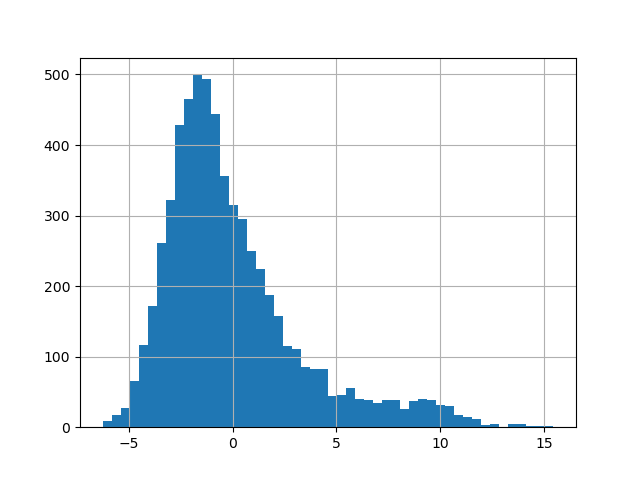

In [34]:
event_features_df["compression_score"].hist(bins=50)


## Non-Shock histogramming

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BAR_MINUTES = 5
PRE_BARS  = 12 * 60 // BAR_MINUTES   # 144
BASE_BARS = 72 * 60 // BAR_MINUTES   # 864

# extra exclusion after shock to avoid post-shock regime bleeding into "non-event"
POST_EXCLUDE_BARS = 12   # 1h = 12 bars


In [38]:
def build_forbidden_mask(df_index, event_ts_list, pre_bars=PRE_BARS, post_bars=POST_EXCLUDE_BARS):
    n = len(df_index)
    forbid = np.zeros(n, dtype=bool)

    # positions of event timestamps in this df index
    # (event_ts should already be aligned; if not, nearest-match with method='pad' but that can introduce noise)
    locs = df_index.get_indexer(event_ts_list)
    locs = locs[locs >= 0]  # keep only those found

    for loc in locs:
        a = max(0, loc - pre_bars)
        b = min(n, loc + post_bars + 1)
        forbid[a:b] = True

    return forbid

rng = np.random.default_rng(42)

def sample_non_event_timestamps(dfs, events, per_symbol_cap=None):
    # group event timestamps by symbol
    ev_by_sym = events.groupby("symbol")["event_ts"].apply(list).to_dict()

    sampled = []  # list of dicts {symbol, event_ts}

    for sym, df in dfs.items():
        if sym not in ev_by_sym:
            continue

        idx = df.index
        if len(idx) <= BASE_BARS + PRE_BARS + 10:
            continue

        event_ts_list = ev_by_sym[sym]
        forbid = build_forbidden_mask(idx, event_ts_list)

        # valid candidates must:
        # - have 72h baseline available => loc >= BASE_BARS
        # - not be forbidden
        valid_mask = np.ones(len(idx), dtype=bool)
        valid_mask[:BASE_BARS] = False
        valid_mask &= ~forbid

        valid_locs = np.flatnonzero(valid_mask)
        if len(valid_locs) == 0:
            continue

        # target sample count = number of shocks for this symbol (or cap)
        k = len(event_ts_list)
        if per_symbol_cap is not None:
            k = min(k, per_symbol_cap)

        k = min(k, len(valid_locs))
        chosen_locs = rng.choice(valid_locs, size=k, replace=False)

        for loc in chosen_locs:
            sampled.append({"symbol": sym, "event_ts": idx[loc]})

    return pd.DataFrame(sampled)


In [39]:
non_events = sample_non_event_timestamps(dfs, events)
len(non_events), non_events.head()


(6287,
    symbol            event_ts
 0  0GUSDT 2025-12-27 13:35:00
 1  0GUSDT 2026-01-05 20:55:00
 2  0GUSDT 2025-11-03 10:55:00
 3  0GUSDT 2025-12-05 11:55:00
 4  0GUSDT 2026-01-01 08:45:00)

In [40]:
rows = []
for _, row in non_events.iterrows():
    sym = row["symbol"]
    ts  = row["event_ts"]
    df = dfs[sym]

    feats = extract_pre_shock_features(df, ts)
    if feats is None:
        continue

    feats["symbol"] = sym
    feats["event_ts"] = ts
    rows.append(feats)

non_event_features_df = pd.DataFrame(rows).set_index(["symbol", "event_ts"])
non_event_features_df.describe()


,vol_ratio,atr_ratio,entropy,volume_ratio,failed_breakouts
count,6287.000000,6287.000000,6287.000000,6287.000000,6287.000000
mean,0.951192,0.983038,0.082610,0.990876,5.093367
std,0.276340,0.307539,0.062048,0.515791,2.399564
min,0.080929,0.256010,0.000000,0.040404,0.000000
25%,0.766644,0.780242,0.033454,0.641847,3.000000
50%,0.928638,0.948922,0.070539,0.885419,5.000000
75%,1.104973,1.132652,0.118633,1.214974,7.000000
max,2.459034,4.011660,0.477551,5.010760,24.000000


In [41]:
z_cols = ["vol_ratio", "atr_ratio", "entropy", "volume_ratio"]

mu = event_features_df[z_cols].mean()
sd = event_features_df[z_cols].std()

for col in z_cols:
    non_event_features_df[f"z_{col}"] = (non_event_features_df[col] - mu[col]) / sd[col]

non_event_features_df["compression_score"] = non_event_features_df[
    ["z_vol_ratio", "z_atr_ratio", "z_entropy", "z_volume_ratio"]
].sum(axis=1)


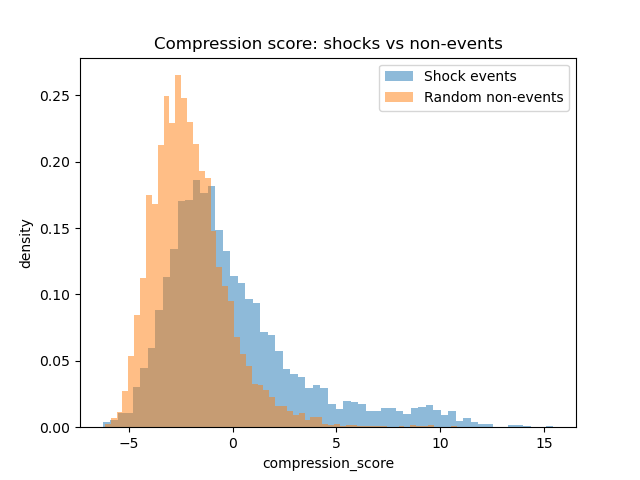

In [42]:
plt.figure()
plt.hist(event_features_df["compression_score"], bins=60, alpha=0.5, density=True, label="Shock events")
plt.hist(non_event_features_df["compression_score"], bins=60, alpha=0.5, density=True, label="Random non-events")
plt.legend()
plt.title("Compression score: shocks vs non-events")
plt.xlabel("compression_score")
plt.ylabel("density")
plt.show()


## Compression Filter

In [43]:
COMPRESSION_THRESH = -2.0
eligible_events = event_features_df[
    event_features_df["compression_score"] < COMPRESSION_THRESH
]
len(eligible_events), len(eligible_events) / len(event_features_df)


(1806, 0.29194956353055285)

In [47]:
RANGE_BARS = 24   # last 2 hours

In [46]:
def find_pre_shock_entry(df, event_ts):
    event_loc = df.index.get_loc(event_ts)

    pre = df.iloc[event_loc - PRE_BARS : event_loc]
    atr_pre = (pre["high"] - pre["low"]).mean()

    # compression range (last 2h)
    comp = pre.iloc[-RANGE_BARS:]
    range_high = comp["high"].max()
    range_low  = comp["low"].min()

    # scan bars after compression range
    scan = pre.iloc[RANGE_BARS:]

    for ts, row in scan.iterrows():
        body = abs(row["close"] - row["open"])

        # long
        if row["close"] > range_high and body > 0.5 * atr_pre:
            return {
                "entry_ts": ts,
                "direction": "long",
                "entry_price": row["close"]
            }

        # short
        if row["close"] < range_low and body > 0.5 * atr_pre:
            return {
                "entry_ts": ts,
                "direction": "short",
                "entry_price": row["close"]
            }

    return None


In [48]:
entries = []

for (sym, ts), row in eligible_events.iterrows():
    df = dfs[sym]
    res = find_pre_shock_entry(df, ts)
    if res is None:
        continue

    res["symbol"] = sym
    res["event_ts"] = ts
    res["compression_score"] = row["compression_score"]
    entries.append(res)

entries_df = pd.DataFrame(entries)
entries_df.head()


,entry_ts,direction,entry_price,symbol,event_ts,compression_score
0,2025-09-25 06:45:00,long,4.211,0GUSDT,2025-09-25 16:45:00,-3.861149
1,2025-09-25 14:00:00,short,3.751,0GUSDT,2025-09-26 00:00:00,-4.500802
2,2025-09-27 17:25:00,short,3.495,0GUSDT,2025-09-28 02:30:00,-4.197668
3,2025-09-30 14:35:00,short,2.448,0GUSDT,2025-10-01 00:30:00,-2.855817
4,2025-10-02 05:30:00,long,2.732,0GUSDT,2025-10-02 15:30:00,-3.006042


In [49]:
entries_df.describe()

,entry_ts,entry_price,event_ts,compression_score
count,1472,1472.000000,1472,1472.000000
mean,2025-08-12 13:49:04.769021952,26.459441,2025-08-12 22:14:37.377717248,-3.067155
min,2025-01-29 14:45:00,0.000005,2025-01-29 20:25:00,-6.276083
25%,2025-05-01 11:07:30,0.109150,2025-05-01 20:33:45,-3.557788
50%,2025-09-14 21:05:00,0.591250,2025-09-15 04:47:30,-2.862883
75%,2025-11-11 00:28:45,2.811750,2025-11-11 10:00:00,-2.406140
max,2026-01-27 09:15:00,4331.400000,2026-01-27 19:15:00,-2.000729
std,NaN,157.483702,NaN,0.838033


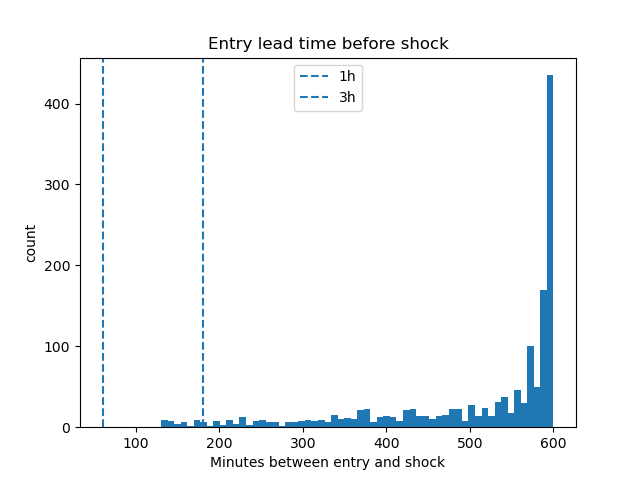

In [50]:
dt_minutes = (
    entries_df["event_ts"] - entries_df["entry_ts"]
).dt.total_seconds() / 60

plt.figure()
plt.hist(dt_minutes, bins=60)
plt.axvline(60, linestyle="--", label="1h")
plt.axvline(180, linestyle="--", label="3h")
plt.xlabel("Minutes between entry and shock")
plt.ylabel("count")
plt.title("Entry lead time before shock")
plt.legend()
plt.show()


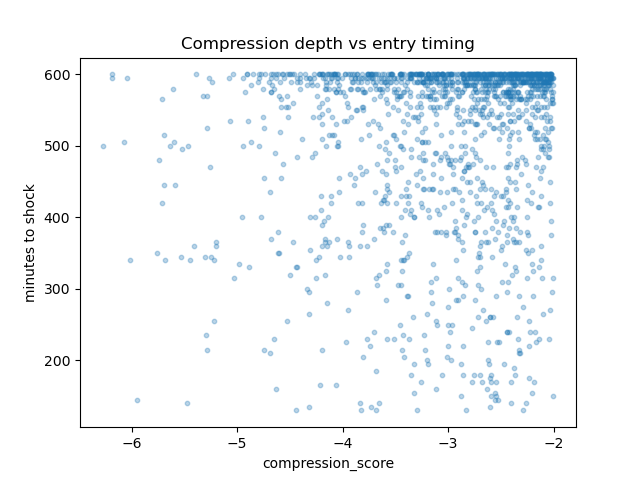

In [51]:
plt.figure()
plt.scatter(
    entries_df["compression_score"],
    dt_minutes,
    alpha=0.3,
    s=10
)
plt.xlabel("compression_score")
plt.ylabel("minutes to shock")
plt.title("Compression depth vs entry timing")
plt.show()


In [52]:
entries_df["direction"].value_counts(normalize=True)


direction
short    0.681386
long     0.318614
Name: proportion, dtype: float64

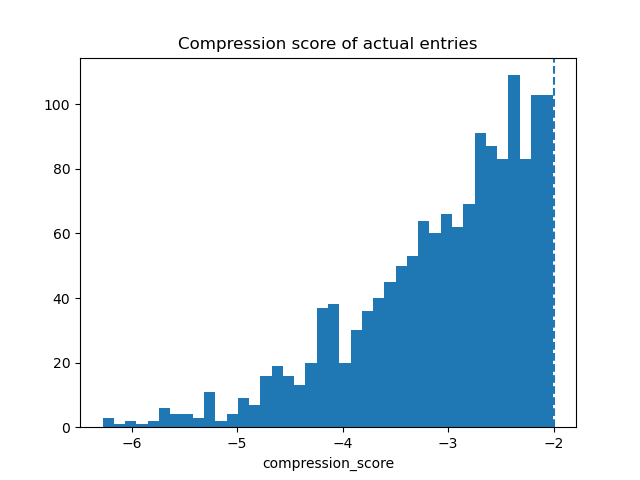

In [53]:
plt.figure()
plt.hist(entries_df["compression_score"], bins=40)
plt.axvline(-2.0, linestyle="--")
plt.xlabel("compression_score")
plt.title("Compression score of actual entries")
plt.show()
